# <span>Binary Classifier Notebook</span>

## 30 Day Readmission Risk for Patients with Diabetes

The main objective of this notebook is to provide an example on how to utilize the seismometer package to analyze a binary classification predictive model.

This notebook helps evaluate a binary classification model trained on the [Diabetes Dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). This model predicts the risk of readmission within 30 days for patients with diabetes. The model used is a simple LightGBM model and used only to provide an example on how the seismometer package could be set up/utilized.

Basic preprocessing steps have already been completed on the dataset. The prepared data is used in training the model and model performance analysis.

### Documentation
To find out more about ``seismometer``, see the [documentation](https://epic-open-source.github.io/seismometer/) on GitHub.

### Usage
Explore data from your organization's model including predictions, outcomes, interventions, and sensitive cohorts.
Use ```sm.show_info()``` to explore what is available.

In [2]:
# Download dataset
import urllib.request
DATASET_SOURCE = "https://raw.githubusercontent.com/epic-open-source/seismometer-data/main"
_ = urllib.request.urlretrieve(f"{DATASET_SOURCE}/diabetes/predictions.parquet", "data/predictions.parquet")
_ = urllib.request.urlretrieve(f"{DATASET_SOURCE}/diabetes/events.parquet", "data/events.parquet")
_ = urllib.request.urlretrieve(f"{DATASET_SOURCE}/diabetes/data_dictionary.yml", "dictionary.yml")
# We assume the existence of the following files in the same directory as the notebook: config.yml, usage_config.yml and data/metadata.json

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

In [2]:
%matplotlib inline

import seismometer as sm
sm.run_startup(config_path='.')

In [3]:
sm.show_info(plot_help=True)

Dataframe Name,Rows,Columns,Content
predictions,99340,3,"Scores, features, configured demographics, and merged events for each prediction"


## Overview

### ℹ Info

A LightGBM model trained on the [Diabetes Dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) predicts if a diabetes patient will be readmitted in the 30 days time window after discharge. The first step is to provide the required information which includes configuration files, predictions data, and events data (interventions, outcomes, or target events). Datasets should be stored in the _parquet_ format. 

The _seismometer_ package pulls configuration from the _config.yml_ file. This file stores:  
<ol>
<li>the filepath to the predictions dataframe in parquet format,</li>
<li>the filepath to the events dataframe in parquet format,</li>
<li>the filepath to usage configuration that describes how to interpret data during run,</li>
<li>the filepath to events definitions, that specify events,</li>
<li>the filepath to predictions definitions, that specify cohorts, scores, and features to consider.</li>
</ol>

 have created: 
<ol>
<li>the predictions dataset, where each row is a patient/encounter and columns are input features, a patient identifier, the time of the prediction, and a score column corresponding to the output of the trained LightGBM model,</li>
<li>the events dataset, where each row corresponds to a target, intervention, or outcome. Here there is only one event defined for the model: the target (<i>y</i>) of the train. The dataset also includes the patient identifier, the time of the event, the type of the event (relevant when there are multiple events) and the events value (in this example, a 1 indicates a readmission occurred within 30 days)</li>
<li>the usage_config.yml data_usage node specifies:
<ol>
<li>age, race and gender as the analysis cohort attributes,</li>
<li>the LightGBM model as the primary output (score),</li>
<li>30 days readmission (<i>readmitted</i> column) event as the primary target,</li>
<li>admission_type_id, num_medications and num_procedures as the only extra features to consider in feature analysis.</li>
</ol>
</li>
</ol>

**Tips:** 

 - Run the cell below to create an `ipywidget` selector. Selectors are linked across notebook cells, and will dynamically update visualizations and reports throughout the notebook. You can also call `sm.cohort_selector()` in a new notebook cell to create the same selector elsewhere.  
 - Use the selector to stratify certain plots and reports across cohorts.

#### Selection

You can specify the sensitive cohorts for a more detailed study in usage_config.yml via the _cohorts_ keyword. As mentioned above, there are three cohort attributes:
<ol>
<li>age: the age group of the patient. Age groups are [0,10), [10,20), [20,50), [50,70) and 70+.</li>
<li>race: the self-reported race of the patient. Race cohorts are 'Caucasian', 'AfricanAmerican', 'Hispanic', 'Asian', 'Other', 'Unknown'.</li>
<li>gender: the self-reported gender of the patient. Gender cohorts are 'Female', 'Male'.</li>
</ol>

In [4]:
sm.cohort_list()

## Feature Monitor

### ℹ Info

In this section is useful for digging into any of the potential data quality alerts identified for the diabetes dataset. Click on the links below to open one of the reports.

**Tips**: 

 - See [feature monitoring](https://epic-open-source.github.io/seismometer/user_guide/index.html#feature-monitor) for more details.
 - This section provides insight into model inputs, demographics, and the set of interventions and outcomes. During early stages this will help validate configuration; afterwards it will assist with detecting feature and population drift. Read through the alerts identified for your data, dig deeper using the feature, demographic, and event summaries, or by comparing across targets or demographics.
 - **Other Warnings:** The variable profiles below will identify any concerning trends in feature distributions. Depending on the model, you may want to do additional configuration to silence these alerts until certain thresholds are met. 
 - Run the `sm.feature_summary()`/`sm.cohort_comparison_report()`/`sm.target_feature_summary()` functions in the cells below to get a report for the corresponding dataset.

### Reports

#### Feature Alerts
View automatically identified data quality issues for the model inputs in your dataset

In [5]:
sm.feature_alerts()

HTML(value='<style>.widget-html-content > code { padding:2px 4px;font-size:90%;color:#c7254e;background-color:…

GridBox(children=(Button(description='Imbalance', disabled=True, layout=Layout(width='95%'), style=ButtonStyle…

#### Feature Summary Statistics and Plots
View the summary statistics and distributions for the model inputs in your dataset. 

In [6]:
sm.feature_summary()

#### Summarize Features by Cohort Subgroup
Run `sm.cohort_comparison_report()`, select two different groups to compare, and hit `Generate Report` to generate a comparative feature report.

In [7]:
sm.cohort_comparison_report()

#### Summarize Features by Target
Run `sm.target_feature_summary()` to get a link to a breakdown of your features stratified by the different target values.

In this example, there is a single target of interest: the 'readmitted' column from the original dataset.

In [8]:
sm.target_feature_summary()

## Model Performance

### Overall

####  ℹ Info

**Model Performance Plots**

See [model performance plots](https://epic-open-source.github.io/seismometer/user_guide/index.html#model-performance) for more details.

**Tips:**

 - Thresholds configured for the model are highlighted on the graphs.
 - Use `sm.model_evaluation()` to get model evaluation plots for your model at the observation level.
 - Use `sm.model_evaluation(per_context_id=True)` to get model evaluation plots for your model at the encounter level.

#### Visuals

In [9]:
sm.model_evaluation()

In [10]:
sm.model_evaluation(per_context_id=True)

### Fairness Overview

#### ℹ Info

See [fairness audit](https://epic-open-source.github.io/seismometer/user_guide/index.html#fairness-audit) for more details.

This section is useful for investigating the 'fairness' of the LightGBM model trained on the diabetes dataset.

In [11]:
sm.fairness_audit(metric_list=['tpr', 'fpr', 'pprev', 'precision'], fairness_threshold=1.25)

alt.VConcatChart(...)

### Cohort Analysis 

In [12]:
sm.show_cohort_summaries(by_target=False, by_score=False)

,Predictions,Entities
Cohort,,
[0-10),155,147
[10-20),679,524
[20-50),15009,10448
[50-70),39054,27505
70+,44443,30101
,Predictions,Entities
Cohort,,
AfricanAmerican,18777,12418
Asian,626,477


#### ℹ Info

**Cohort Performance Plots**

See [cohort comparisons](https://epic-open-source.github.io/seismometer/user_guide/index.html#cohort-analysis) for more details.

**Tips:**

 - Thresholds configured for the model are highlighted on the graphs.
 - Use `sm.cohort_evaluation()` to get model evaluation plots for your model at the observation level.
 - Use `sm.cohort_evaluation(per_context_id=True)` to get model evaluation plots for your model at the encounter level.

#### Visuals

In [13]:
sm.cohort_selector()

DisjointSelectionListsWidget(value=('Age', ('[0-10)', '[10-20)', '[20-50)', '[50-70)', '70+')), children=(Labe…

In [14]:
sm.cohort_evaluation()

In [15]:
sm.cohort_evaluation(per_context_id=True)

## Outcomes

Success of integrating a predictive model depends on more than just the model's performance. Often, it can be determined by how well the model is integrated and how effectively (and equitably) interventions are applied. This section is intended to help analyze interventions and outcomes across sensitive groups or risk categories. See [analyzing outcomes](https://epic-open-source.github.io/seismometer/user_guide/index.html#outcomes) for more details.

### Lead-time Analysis 

#### ℹ Info

Lead-time analysis is focused on revealing the amount of time that a high prediction gives before an event of interest.  These analyses implicitly restrict data to the positive cohort, as that is expected to be the place time the event occurs.
The visualization uses violin plots, where each distribution of the subpopulation is represented as a vertical, mirrored density plot. The inner box within the violin plot highlights the interquartile range, while the central line indicates the median. When the distributions overlap significantly, it indicates that the model is providing equal opportunity for action to be taken based on the scores across the cohort groups.

#### Visuals

In [1]:
sm.plot_leadtime_enc()

NameError: name 'sm' is not defined

## Add Your Own Analysis

You can also incorporate other packages to create your own analyses. This example uses the seaborn package to create a heatmap of average score across different age groups and procedure counts.

`sm.Seismogram().dataframe` is a pandas DataFrame with merged predictions and events data.

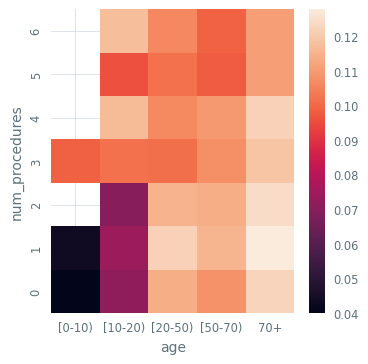

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd

sg = sm.Seismogram()
heat = sg.dataframe[["num_procedures","age","LGBM_score"]]
heat = pd.DataFrame(heat.groupby(["num_procedures","age"],observed=False)["LGBM_score"].agg('mean')).reset_index()
heat["num_procedures"] = heat["num_procedures"].astype('category').cat.reorder_categories([6,5,4,3,2,1,0])
hm = sns.heatmap(data = heat.pivot(index="num_procedures", columns="age", values="LGBM_score"))
  
# displaying the plotted heatmap 
plt.show()